# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%aimport mc.util 
from util import *
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
import os
import pyximport; pyximport.install()

import mc.cutil
from mc.cutil import *

plt.style.use('ggplot')
matplotlib.rcParams["mathtext.fontset"] = "cm"

os.environ['CC'] = 'clang'
os.environ['CXX'] = 'clang -shared'

# T=0

## Monomers

In [ ]:
# data1 = read_accumulator("data/t0j0/doped/-1/96x96_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=10)[0].reshape((96, 96))
# data2 = read_accumulator("data/t0j0/doped/-1/120x120_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=10)[0].reshape((120, 120))

# data1 = read_accumulator("data/t0j0/doped2/-1/96x96_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=0)[0].reshape((96, 96))
# data2 = read_accumulator("data/t0j0/doped2/-1/120x120_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=0)[0].reshape((120, 120))

data1 = read_accumulator("new-data/t0j0/84x84_r-3_t0.000000_j0.000_200000000.20_1/mono-mono.dat", skip=10)[0].reshape((84, 84))
# data1 = read_accumulator("new-data/t0j0/96x96_r-3_t0.000000_j0.000_200000000.10_0/mono-mono.dat", skip=10)[0].reshape((96, 96))
data2 = read_accumulator("new-data/t0j0/120x120_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=0)[0].reshape((120, 120))

fig, ax = plt.subplots(2, 2, figsize=[8, 5])
plot2d(ax[0, 0], data1)
plot2d(ax[0, 1], data2)

def mod(data, x, y):
    return data.T[x%(data.shape[0]), y%(data.shape[1])]

def symmetrize(data):
    lin = [0]
    xs = np.arange(data.shape[0]//2)
    for i in range(1, data.shape[0]//2):
        total = 0
        total += mod(data, 0, i)
        total += mod(data, i, 0)
        total += mod(data, -i, i)
        total += mod(data, -i, 0)
        total += mod(data, -i, -i)
        total += mod(data, i, -i)
        lin.append(total / 6)
    lin = np.array(lin)

    L = data.shape[0]
    xs = np.sin(np.pi/L * xs) / (np.pi/L)

    indices = np.arange(len(xs))
    return xs[indices % 3 != 0], lin[indices % 3 != 0]

def fit(xs, ys):
    import scipy

    def fun(x, A, B):
        return B * np.power(np.abs(x), A)
    param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-0.25, 0.002])

    return fun, param

x1, y1 = symmetrize(data1)
fun, param = fit(x1[:], y1[:])
ax[1, 0].scatter(x1, y1)
ax[1, 0].plot(x1, fun(x1, *param), label=f"B={param[0]}")
# ax[1, 0].set_yscale("log")
# ax[1, 0].set_xscale("log")
ax[1, 0].legend()

x2, y2 = symmetrize(data2)
fun, param = fit(x2[:], y2[:])
ax[1, 1].scatter(x2, y2)
ax[1, 1].plot(x2, fun(x2, *param), label=f"B={param[0]}")
# ax[1, 1].set_yscale("log")
# ax[1, 1].set_xscale("log")
ax[1, 1].legend()

### CFT scaling collapse

In [47]:
L, data, N = get_all_data("new-data/t0j0/*r-3*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=10000, by="l", with_counts=True)

merged_data = {}
for l, d, n in zip(L, data, N):
    if l not in merged_data:
        # take horizontal cut
        merged_data[l] = (d[:, 0], n)
    else:
        prev_n = merged_data[l][1]
        merged_data[l] = ((merged_data[l][0] * prev_n + d[:, 0] * n) / (prev_n + n), prev_n + n)

L, data, N = get_all_data("new-data/t0j0/*r-6*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=10000, by="l", with_counts=True)

merged_data2 = {}
for l, d, n in zip(L, data, N):
    if l not in merged_data2:
        # take horizontal cut
        merged_data2[l] = (d[:, 0], n)
    else:
        prev_n = merged_data2[l][1]
        merged_data2[l] = ((merged_data2[l][0] * prev_n + d[:, 0] * n) / (prev_n + n), prev_n + n)

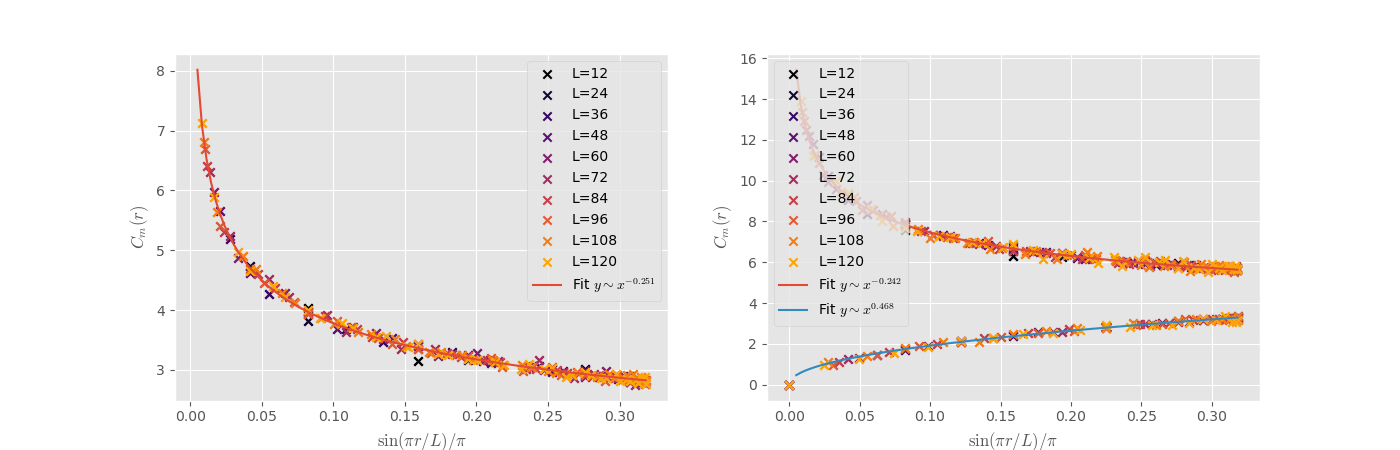

In [55]:
def plot(ax, merged_data):
    xs1 = []
    ys1 = []
    xs2 = []
    ys2 = []
    colors = gen_colors(L)

    for l, pair in merged_data.items():
        d, total_n = pair
        x = np.arange(l)
        scaledx = np.sin(np.pi * x/l) / (np.pi/l)
        scaledx = scaledx/l

        d = d * l**2
        if d[3] > 0:
            ax.scatter(scaledx, d, marker="x", color=colors[l], label="L="+str(l))
        else:
            ax.scatter(scaledx[x%3!=0], d[x%3!=0], marker="x", color=colors[l], label="L="+str(l))

        for i in range(0, d.shape[0]//2):
            if i % 3 != 0:
                xs1.append(scaledx[i])
                ys1.append(d[i])
            else:
                xs2.append(scaledx[i])
                ys2.append(d[i])

    x = np.linspace(0.005, 1/np.pi, 100)

    # def fun(x, A, B, C):
    #     return B * np.exp(np.abs(x) / A) + C
    # param, _ = scipy.optimize.curve_fit(fun, xs[:20], ys[:20], p0=[-0.25, 1, 1/16], bounds=([-5, -np.inf, 0], [-0.01, np.inf, 100]))
    # plt.plot(x, fun(x, *param), label=f"Fit $y={param[1]:.2f}e^{{-x/{-param[0]:.2f}}}+{param[2]:.3f}$")

    def fun(x, A, B):
        return B * np.power(np.abs(x), A)
    param, _ = scipy.optimize.curve_fit(fun, xs1, ys1, p0=[-0.25, 1], bounds=([-1, -np.inf], [0, np.inf]))
    ax.plot(x, fun(x, *param), label=f"Fit $y\\sim x^{{{param[0]:.3f}}}$")

    if np.mean(ys2) > 0.01:
        def fun(x, A, B):
            return B * np.power(np.abs(x), A)
        param, _ = scipy.optimize.curve_fit(fun, xs2, ys2, p0=[0.5, 1], bounds=([0, -np.inf], [1, np.inf]))
        ax.plot(x, fun(x, *param), label=f"Fit $y\\sim x^{{{param[0]:.3f}}}$")

    ax.legend()
    ax.set_ylabel("$C_m(r)$")
    ax.set_xlabel("$\\sin(\\pi r/L) / \\pi$")

plt.close("all")
fig, ax = plt.subplots(1, 2, figsize=[14, 4.5])
plot(ax[0], merged_data)
plot(ax[1], merged_data2)

## Trimers

### Scaling

In [24]:
L, data, N = get_all_data("new-data/t0j0/*/tri-tri.dat", lambda data, props: data[0].reshape((props["l"], props["l"], 2)), skip=100000, by="l", with_counts=True)

merged_data = {}
for l, d, n in zip(L, data, N):
    if l not in merged_data:
        merged_data[l] = (d[:, :, :], n)
    else:
        prev_n = merged_data[l][1]
        merged_data[l] = ((merged_data[l][0] * prev_n + d[:, :, :] * n) / (n + prev_n), n + prev_n)

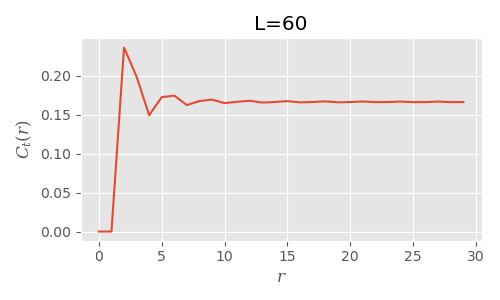

In [39]:
plt.figure(figsize=[5, 3])
plt.plot(merged_data[60][0][:30, 0, 0])
plt.xlabel("$r$")
plt.ylabel("$C_t(r)$")
plt.title("L=60")
plt.tight_layout()

Text(0, 0.5, '$C_t(L/2)$')

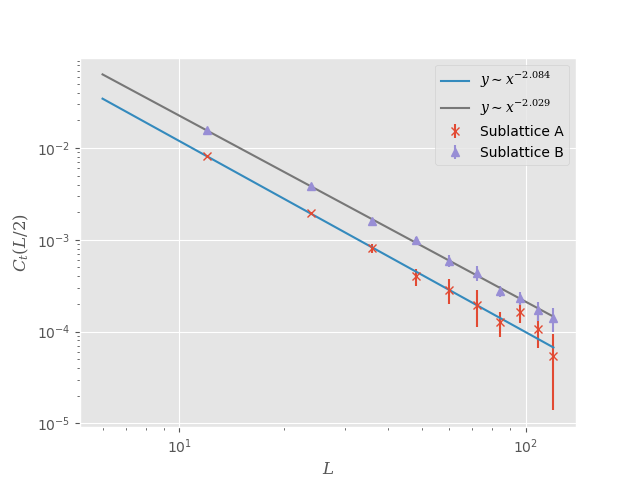

In [38]:
def fit(xs, ys):
    def fun(x, A, B):
        return B * np.power(np.abs(x), A)
    param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-2, 0.001])
    return fun, param

values = []
values2 = []
ns = []
ls = []
for l, pair in merged_data.items():
    d, n = pair
    ls.append(l)
    values.append(d[l//2, 0, 0])
    values2.append(d[l//2, 0, 1])
    ns.append(n)

ls = np.array(ls)
values = np.array(values) - 1/6
values2 = -(np.array(values2) - 1/6)
ns = np.array(ns)

plt.figure()
xs = np.linspace(6, 120, 30)

n_per_sample = 4
plt.errorbar(ls, values, yerr=np.sqrt((values+1/6)*(5/6-values))/np.sqrt(ns*n_per_sample), ls="", marker="x", label="Sublattice A")
fun, param = fit(ls, values)
plt.plot(xs, fun(xs, *param), label=f"$y\\sim x^{{{param[0]:.3f}}}$")

plt.errorbar(ls, values2, yerr=np.sqrt((values2+1/6)*(5/6-values2))/np.sqrt(ns*n_per_sample), ls="", marker="^", label="Sublattice B")
fun, param = fit(ls, values2)
plt.plot(xs, fun(xs, *param), label=f"$y\\sim x^{{{param[0]:.3f}}}$")

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("$L$")
plt.ylabel("$C_t(L/2)$")

## Entropy per trimer

/tmp/ipykernel_449523/3685139866.py:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  entropies.append(scipy.integrate.quad(fun, ts2[0], ts2[-1], limit=200)[0])


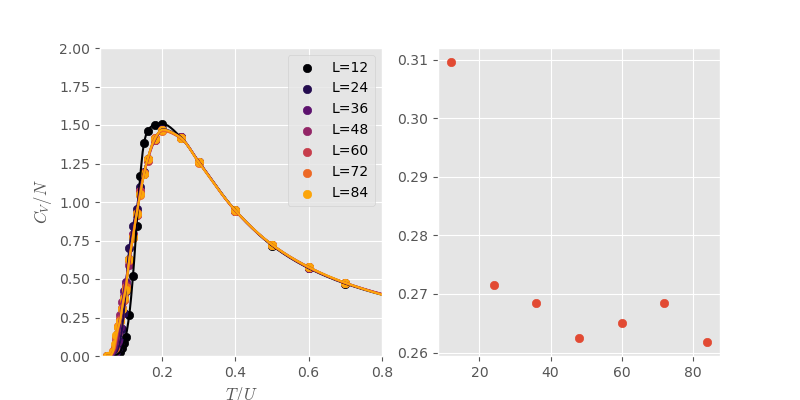

In [159]:
plt.close("all")
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
ax[0].set_ylabel("$C_V/N$")
ax[0].set_xlabel("$T/U$")
ax[0].set_xlim([0.03, 0.8])
ax[0].set_ylim([0, 2])

skip = 300000
ls = [12, 24, 36, 48, 60, 72, 84]
entropies = []
colors = gen_colors(ls)
for L in ls:
    ts1, ds1 = get_all_cvs(f"new-data/vsweeps/single/0/{L}x{L}_r-0_t*_j0.000_20000000.20_0/energy.dat", skip=skip)

    interp = lambda x: np.piecewise(x, [x<0.06, (0.06<=x)*(x<50), 50<=x], [0, scipy.interpolate.PchipInterpolator(ts1, ds1), 0])
    # interp = lambda x: scipy.interpolate.splev(x, scipy.interpolate.splrep(ts1, ds1, s=0.002))

    fun = lambda x: interp(x) / x

    ts2 = np.geomspace(np.amin(ts1), np.amax(ts1), 200)
    entropies.append(scipy.integrate.quad(fun, ts2[0], ts2[-1], limit=200)[0])

    ax[0].scatter(ts1, ds1, label="L="+str(L), color=colors[L])
    ax[0].plot(ts2, interp(ts2), color=colors[L])

ls = np.array(ls)
entropies = np.array(entropies)
ax[0].legend()

def S(n):
    return 6 * np.log(6) - 5 * np.log(5) - 1/2/n * np.log(5*np.pi*n/3)
ax[1].scatter(ls, S(ls**2/3)-entropies)

def fun(x, A, B):
    return A + B/x
# param, _ = scipy.optimize.curve_fit(fun, ls[:-1], S(ls[:-1]**2/3)-entropies[:-1])
# xs =np.linspace(6, 84, 20)
# ax[1].plot(xs, fun(xs, *param))
# print(param)

# T>0

## Strong transitions

### J=0.01

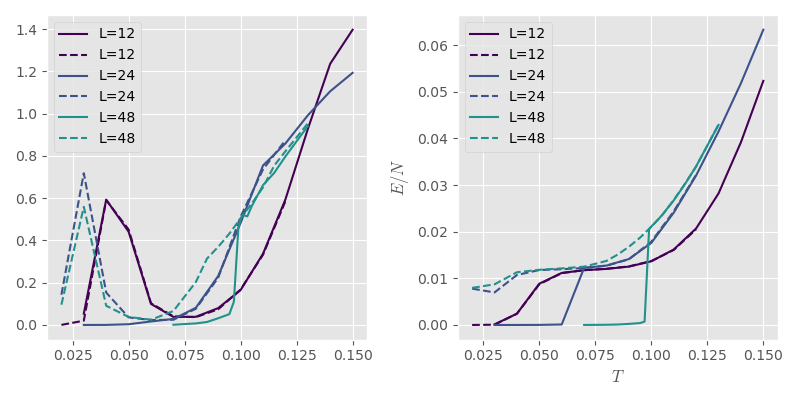

In [7]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
skip=100000

Ls = [12, 24, 48]
colors = [matplotlib.colormaps["viridis"](x) for x in np.linspace(0, 1, 5)]
colormap = {Ls[i]: colors[i] for i in range(len(Ls))}

for l in Ls:
    for init in ["rt3", "rand"]:
        ls = "--" if init == "rand" else None
        ts2, ds2 = get_all_cvs(f"new-data/vsweeps/rough/0.01/{init}/{l}*/energy.dat", skip=skip)
        ax[0].plot(ts2, ds2, label="L="+str(l), ls=ls, color=colormap[l])
        ts2, ds2 = get_all_energies(f"new-data/vsweeps/rough/0.01/{init}/{l}*/energy.dat", skip=skip)
        ax[1].plot(ts2, ds2, label="L="+str(l), ls=ls, color=colormap[l])
ax[0].legend()
ax[1].legend()
ax[1].set_ylabel("$E/N$")
ax[1].set_xlabel("$T$")
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 2)
skip=0

Ls = [12, 24, 36, 48]
colors = [matplotlib.colormaps["viridis"](x) for x in np.linspace(0, 1, 5)]
colormap = {Ls[i]: colors[i] for i in range(len(Ls))}

for l in Ls:
    for init in ["rt3", "rand"]:
        ls = "--" if init == "rand" else None
        ts2, ds2 = get_all_cvs(f"new-data/pto/0.01/{init}/{l}*/energy.dat", skip=skip)
        ax[0].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
        ts2, ds2 = get_all_energies(f"new-data/pto/0.01/{init}/{l}*/energy.dat", skip=skip)
        ax[1].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
ax[0].legend()
ax[1].legend()

### J=-0.1

In [ ]:
fig, ax = plt.subplots(1, 2)
skip=100000

Ls = [24, 36, 48]
colors = [matplotlib.colormaps["viridis"](x) for x in np.linspace(0, 1, 5)]
colormap = {Ls[i]: colors[i] for i in range(len(Ls))}

for l in Ls:
    for init in ["bw", "rand"]:
        ls = "--" if init == "rand" else None
        ts2, ds2 = get_all_cvs(f"new-data/vsweeps/rough/-0.1/{init}/{l}*/energy.dat", skip=skip)
        ax[0].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
        ts2, ds2 = get_all_energies(f"new-data/vsweeps/rough/-0.1/{init}/{l}*/energy.dat", skip=skip)
        ax[1].plot(ts2, ds2, label=init+str(l), ls=ls, color=colormap[l])
ax[0].legend()
ax[1].legend()

### Structure factor evolution

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=[15, 6])

for i, t in enumerate([0.33, 0.335579, 0.346369, 0.348]):
    data = read_accumulator(f"new-data/vsweeps/binder/2/48x48_r-0_t{t:.6f}_j2.000_30000000.15_0/tri-tri.dat")[0].reshape((48, 48, 2))
    plot2d_hex(ax[0, i], data)
    plot_FT(ax[1, i], FT_hex(data), proj="logabs")
    ax[0, i].set_title(f"t={t}")
fig.suptitle("J=2 L=48")

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=[15, 6])

for i, t in enumerate([0.265, 0.278170, 0.281064, 0.29]):
    data = read_accumulator(f"new-data/vsweeps/binder/0.3/48x48_r-0_t{t:.6f}_j0.300_30000000.15_0/tri-tri.dat")[0].reshape((48, 48, 2))
    plot2d_hex(ax[0, i], data)
    plot_FT(ax[1, i], FT_hex(data), proj="logabs")
    ax[0, i].set_title(f"t={t}")
fig.suptitle("J=0.3 L=48")

Text(0.5, 0.98, 'J=0.01 L=48')

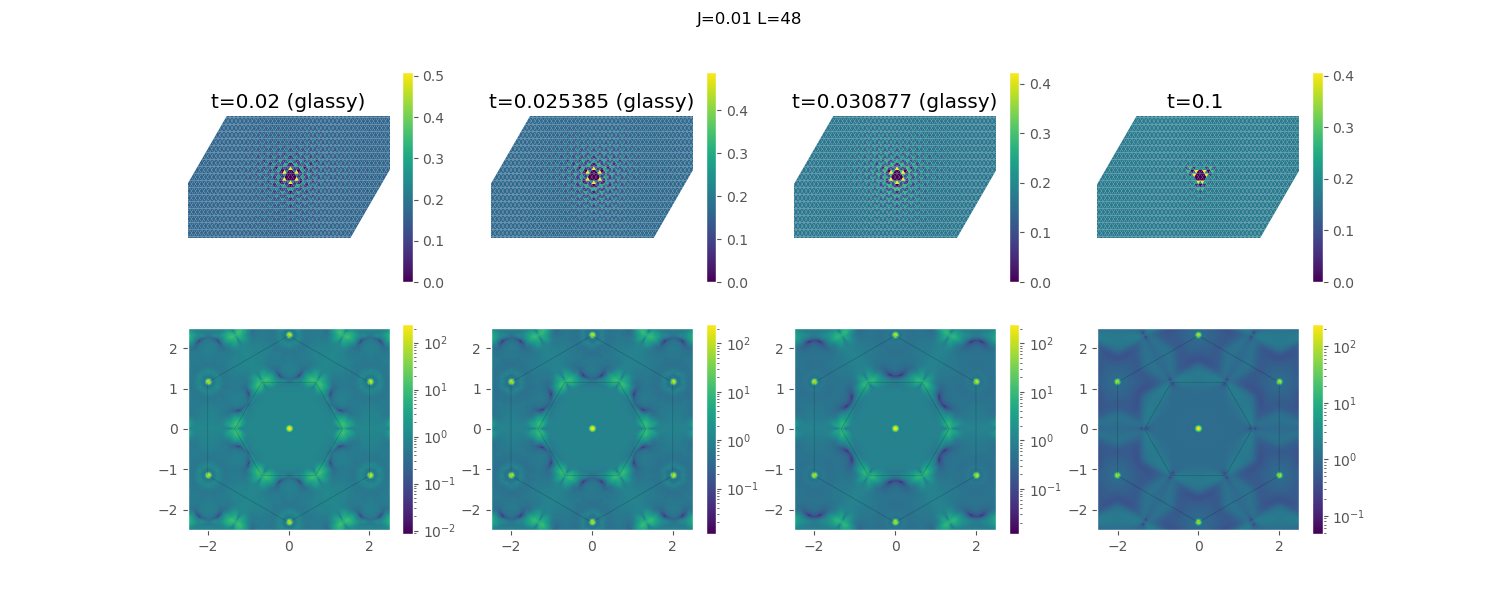

In [162]:
fig, ax = plt.subplots(2, 4, figsize=[15, 6])

for i, t in enumerate([0.02, 0.025385, 0.030877, 0.1]):
    data = read_accumulator(f"new-data/pto/0.01/rand/48x48_r-0_t{t:.6f}_j0.010_30000000.15_0/tri-tri.dat")[0].reshape((48, 48, 2))
    plot2d_hex(ax[0, i], data)
    plot_FT(ax[1, i], FT_hex(data), proj="logabs")
    if t<0.05:
        suffix = "(glassy)"
    else:
        suffix = ""
    ax[0, i].set_title(f"t={t} {suffix}")
fig.suptitle("J=0.01 L=48")

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=[15, 6])

for i, t in enumerate([0.02, 0.029686, 0.033871, 0.05]):
    data = read_accumulator(f"new-data/pto/-0.1/48x48_r-0_t{t:.6f}_j-0.100_30000000.15_0/tri-tri.dat")[0].reshape((48, 48, 2))
    plot2d_hex(ax[0, i], data)
    plot_FT(ax[1, i], FT_hex(data), proj="logabs")
    ax[0, i].set_title(f"t={t}")
fig.suptitle("J=-0.1 L=48")

Text(0.5, 0.98, 'J=0 L=48')

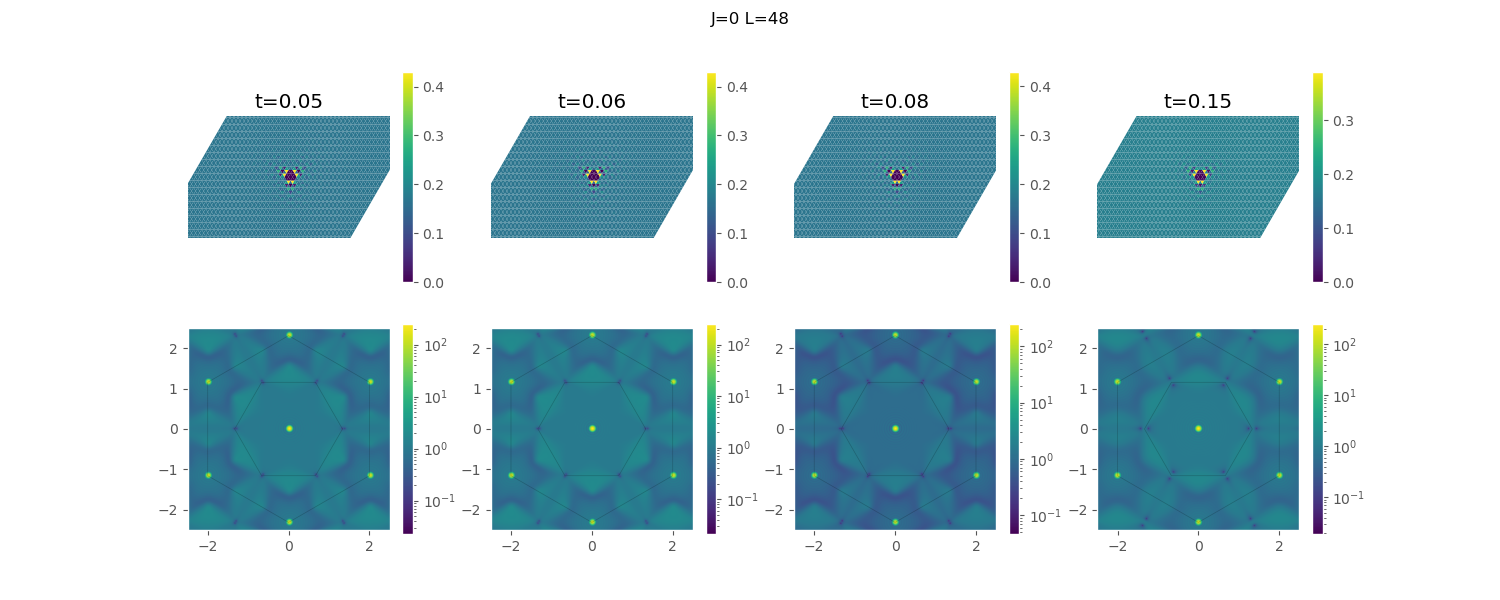

In [161]:
fig, ax = plt.subplots(2, 4, figsize=[15, 6])

for i, t in enumerate([0.05, 0.06, 0.08, 0.15]):
    data = read_accumulator(f"new-data/vsweeps/single/0/48x48_r-0_t{t:.6f}_j0.000_20000000.20_0/tri-tri.dat")[0].reshape((48, 48, 2))
    plot2d_hex(ax[0, i], data)
    plot_FT(ax[1, i], FT_hex(data), proj="logabs")
    ax[0, i].set_title(f"t={t}")
fig.suptitle("J=0 L=48")

## Horizontal sweeps

In [ ]:
skip=10000
fig, ax = plt.subplots(1, 3)
j4, cv = get_all_cvs("new-data/hsweeps/0.1/*/energy.dat", by="j4", skip=skip)
ax[0].plot(j4, cv, label="T=0.10")
j4, cv = get_all_cvs("new-data/hsweeps/0.07/*/energy.dat", by="j4", skip=skip)
ax[0].plot(j4, cv, label="T=0.07")
j4, cv = get_all_cvs("new-data/hsweeps/0.05/*/energy.dat", by="j4", skip=skip)
ax[0].plot(j4, cv, label="T=0.05")
ax[0].legend()

j4, cv = get_all_data("new-data/hsweeps/0.1/*/order.dat", lambda data, props: data[0], by="j4", skip=skip)
ax[1].plot(j4, cv[:, 0])
ax[2].plot(j4, cv[:, 3])
j4, cv = get_all_data("new-data/hsweeps/0.07/*/order.dat", lambda data, props: data[0], by="j4", skip=skip)
ax[1].plot(j4, cv[:, 0])
ax[2].plot(j4, cv[:, 3])
j4, cv = get_all_data("new-data/hsweeps/0.05/*/order.dat", lambda data, props: data[0], by="j4", skip=skip)
ax[1].plot(j4, cv[:, 0])
ax[2].plot(j4, cv[:, 3])

In [ ]:
data = read_accumulator("new-data/hsweeps/0.07/48x48_r-0_t0.070000_j-0.250_20000000.20_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 3)
plot2d_hex(ax[0,0], data)
plot_FT(ax[1,0], FT_hex(data), proj="logabs")

data = read_accumulator("new-data/hsweeps/0.07/48x48_r-0_t0.070000_j-0.025_20000000.20_0/tri-tri.dat")[0].reshape((48, 48, 2))
plot2d_hex(ax[0,1], data)
plot_FT(ax[1,1], FT_hex(data), proj="logabs")

data = read_accumulator("new-data/hsweeps/0.07/48x48_r-0_t0.070000_j0.000_20000000.20_0/tri-tri.dat")[0].reshape((48, 48, 2))
plot2d_hex(ax[0,2], data)
plot_FT(ax[1,2], FT_hex(data), proj="logabs")

## Trimer structure factor

In [ ]:
data1 = read_accumulator("new-data/vsweeps/binder/0.2d/60x60_r-0_t0.246970_j0.200_30000000.15_0/tri-tri.dat")[0].reshape((60, 60, 2))
data2 = read_accumulator("new-data/vsweeps/binder/0.2d/84x84_r-0_t0.246987_j0.200_30000000.15_0/tri-tri.dat")[0].reshape((84, 84, 2))

ft1 = FT_hex(data1)
ft2 = FT_hex(data2)
fig, ax = plt.subplots(1, 2)
xs = np.linspace(0, 0.1, 100)
ys = []
ys2 = []
for x in xs:
    ys.append(np.real(ft1((4/3, x))))
    ys2.append(np.real(ft2((4/3, x))))

def fun(x, A, B):
    return A / (1 + (B * x)**2)

ax[0].plot(xs, ys)
param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=(250, 0.1))
ax[0].plot(xs, fun(xs, *param))

ax[1].plot(xs, ys2)
param, _ = scipy.optimize.curve_fit(fun, xs, ys2, p0=(350, 0.1))
ax[1].plot(xs, fun(xs, *param))

Text(0.5, 1.0, 'J=-0.1 T=0.05 48x48')

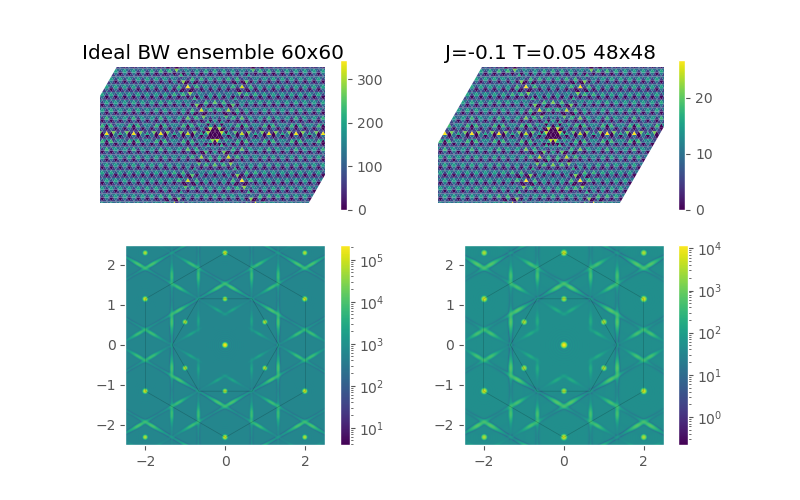

In [52]:
data1 = read_accumulator("data/idealbw/60x60_r-3_uinf_4j0.00_1000.1_0/tri-tri.dat")[0].reshape((60, 60, 2))
data2 = read_accumulator("data/vsweeps/-0.1/48x48_r-0_t0.0300_j-0.1000_40000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 2, figsize=[8, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
ax[0,0].set_title("Ideal BW ensemble 60x60")
ax[0,1].set_title("J=-0.1 T=0.05 48x48")

Text(0.5, 1.0, 'J=0.1 T=0.09 48x48')

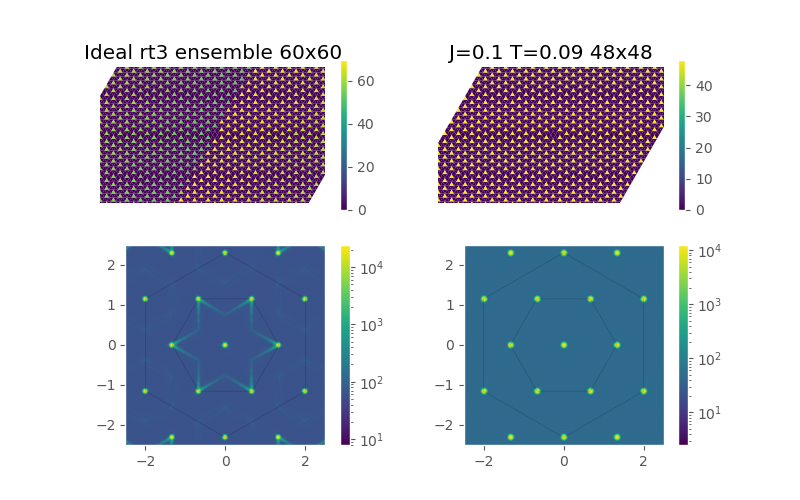

In [160]:
data1 = read_accumulator("data/idealrt3/60x60_r-0_t0.000000_j0.000_10.1_0/tri-tri.dat")[0].reshape((60, 60, 2))
data2 = read_accumulator("data/vsweeps/0.1/48x48_r-0_t0.0900_j0.1000_40000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 2, figsize=[8, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
ax[0,0].set_title("Ideal rt3 ensemble 60x60")
ax[0,1].set_title("J=0.1 T=0.09 48x48")

In [ ]:
data1 = read_accumulator("data/rt3trans/48x48_r-3_uinf_4j0.00_20000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
data2 = read_accumulator("data/vsweeps/0.01/48x48_r-0_t0.5000_j0.0100_40000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 2, figsize=[8, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
ax[0,0].set_title("T=0 J=0 48x48")
ax[0,1].set_title("T=0.5 J=0 48x48")

## Restricted mobility and confinement

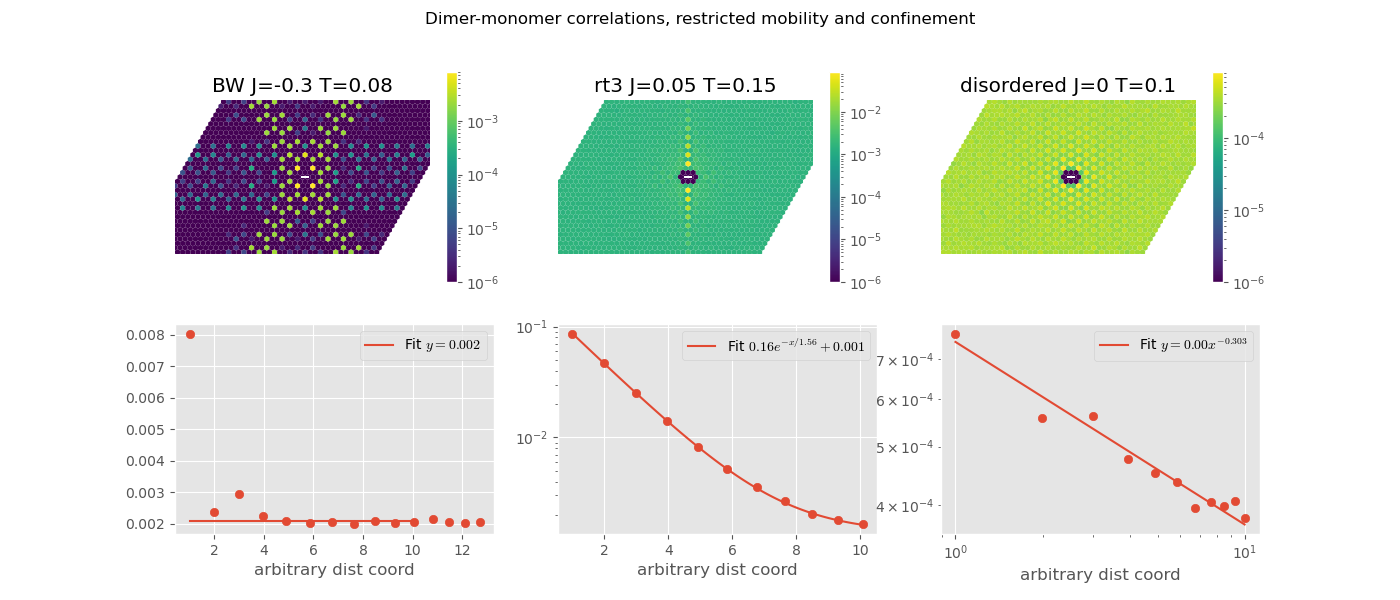

In [69]:
fig, ax = plt.subplots(2, 3, figsize=[14, 6])

fig.suptitle("Dimer-monomer correlations, restricted mobility and confinement")

data1 = read_accumulator("new-data/finite-t/j-0.3t0.08/48x48_r-3_t0.080000_j-0.300_20000000.20_0/mono-di.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0,0], data1, log=True, show_dimer=True)
ax[0,0].set_title("BW J=-0.3 T=0.08")

data2 = read_accumulator("new-data/finite-t/j0.05t0.15/48x48_r-3_t0.150000_j0.050_20000000.20_0/mono-di.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0,1], data2, log=True, show_dimer=True)
ax[0,1].set_title("rt3 J=0.05 T=0.15")

data3 = read_accumulator("new-data/finite-t/j0/48x48_r-3_t0.100000_j0.000_20000000.20_1/mono-di.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0,2], data3, log=True, show_dimer=True)
ax[0,2].set_title("disordered J=0 T=0.1")

def mod(data, x, y):
    return data[x%(data.shape[0]), y%(data.shape[1])]

def symmetrize(data, cut):
    if cut == "perp":
        xs = np.arange(data.shape[0]//4)
        ys = np.zeros_like(xs, dtype=float)
        for i in xs:
            ys[i] = np.mean([mod(data, -i, 1+2*i), mod(data, 1+i, -1-2*i)][0])
    else:
        xs = np.arange(2*(data.shape[0]//6))
        ys = np.zeros_like(xs, dtype=float)
        for i in xs:
            ii = i // 2
            if i % 2 == 0:
                ys[i] = np.mean([mod(data, 0, 1+3*ii), mod(data, -3*ii, 1+3*ii),
                                 mod(data, 1+3*ii, -1-3*ii), mod(data, 1, -1-3*ii)])
            else:
                ys[i] = np.mean([mod(data, 1, 2+3*ii), mod(data, -2-3*ii, 2+3*ii),
                                 mod(data, 3+3*ii, -2-3*ii), mod(data, 0, -2-3*ii)])
    
    xs = np.sin(np.pi * xs/data.shape[0]) / (np.pi/data.shape[0]) 
    return xs[1:], ys[1:]

x = np.linspace(1, 10, 100)

xs, ys = symmetrize(data1, "zigzag")
ax[1, 0].scatter(xs, ys)
def fun(x, A):
    return np.ones_like(x) * A

param, _ = scipy.optimize.curve_fit(fun, xs[3:], ys[3:])
ax[1, 0].plot(x, fun(x, *param), label=f"Fit $y={param[0]:.3f}$")
ax[1, 0].set_xlabel("arbitrary dist coord")
ax[1, 0].legend()

xs, ys = symmetrize(data2, "perp")
ax[1, 1].scatter(xs, ys)
def fun(x, A, B, C):
    return B * np.exp(np.abs(x) / A) + C
param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-0.25, 1, 0])
ax[1, 1].plot(x, fun(x, *param), label=f"Fit ${param[1]:.2f}e^{{-x/{-param[0]:.2f}}}+{param[2]:.3f}$")
ax[1, 1].set_yscale("log")
ax[1, 1].set_xlabel("arbitrary dist coord")
ax[1, 1].legend()

xs, ys = symmetrize(data3, "perp")
ax[1, 2].scatter(xs, ys)
def fun(x, A, B):
    return B * np.power(np.abs(x), A)
param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-0.25, 1], bounds=([-5, 0], [-0.01, np.inf]))
ax[1, 2].plot(x, fun(x, *param), label=f"Fit $y={param[1]:.2f}x^{{{param[0]:.3f}}}$")
ax[1, 2].set_yscale("log")
ax[1, 2].set_xscale("log")
ax[1, 2].set_xlabel("arbitrary dist coord")
ax[1, 2].legend()

Text(0.5, 1.0, 'dis J=0 T=0.10')

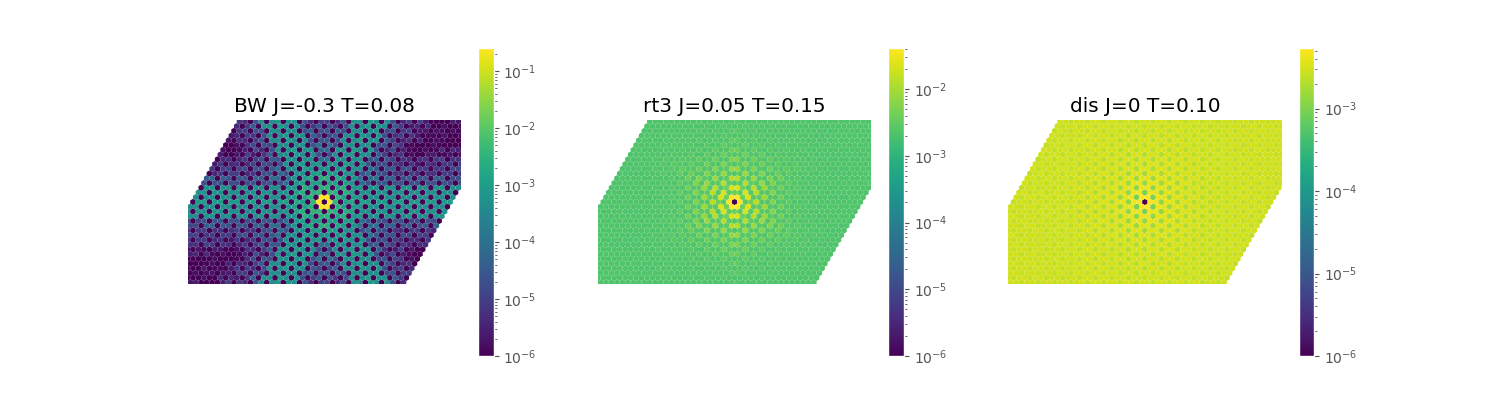

In [70]:
fig, ax = plt.subplots(1, 3, figsize=[15, 4])
data1 = read_accumulator("new-data/finite-t/j-0.3t0.08/48x48_r-3_t0.080000_j-0.300_20000000.20_0/mono-mono.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0], data1, log=True)
ax[0].set_title("BW J=-0.3 T=0.08")

data1 = read_accumulator("new-data/finite-t/j0.05t0.15/48x48_r-3_t0.150000_j0.050_20000000.20_0/mono-mono.dat")[0].reshape((48, 48), order='F')
plot2d(ax[1], data1, log=True)
ax[1].set_title("rt3 J=0.05 T=0.15")

data1 = read_accumulator("new-data/finite-t/j0/48x48_r-3_t0.100000_j0.000_20000000.20_0/mono-mono.dat")[0].reshape((48, 48), order='F')
plot2d(ax[2], data1, log=True)
ax[2].set_title("dis J=0 T=0.10")

## CFT scaling hypothesis

In [143]:
print(T[0])

0.04


/tmp/ipykernel_449523/3205583494.py:36: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 30])


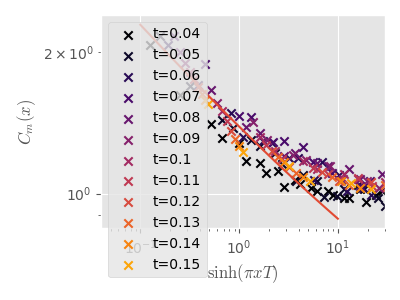

In [150]:
T, data = get_all_data("new-data/finite-t/j0/72*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=100, by="t")

plt.figure(figsize=[4, 3])
xs = []
ys = []
colors = gen_colors(T)
for t, d in zip(T, data):
    l = d.shape[0]
    x = np.arange(l)
    scaledx = np.sinh(np.pi * x * t)

    # c = d[32:39:3, 0].mean() + d[31:39:3, 0].mean()
    c = (d[20:28:3, 0].mean() + d[19:28:3, 0].mean()) / 2
    d = d / c

    plt.scatter(scaledx[(x%3!=0)*(x<l//2)], d[(x%3!=0)*(x<l//2), 0], marker="x", label="t="+str(t), color=colors[t])
    # plt.scatter(scaledx, d[:, 0], marker="x", label="t="+str(t))
    for i in range(d.shape[0]//2):
        if i % 3 == 0: continue
        xs.append(scaledx[i])
        ys.append(d[i, 0])
xs, ys = np.array(xs), np.array(ys)

ind = np.argsort(xs)
xs, ys = xs[ind], ys[ind]

x = np.linspace(0.1, 10, 100)
def fun(x, A, B):
    return A * np.power(np.abs(x), -0.25) + B
param, _ = scipy.optimize.curve_fit(fun, xs[:50], ys[:50])
plt.plot(x, fun(x, *param))

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\\sinh (\\pi x T)$")
plt.xlim([0, 30])
plt.ylabel("$C_m(x)$")
plt.legend()
plt.tight_layout()

[ 0.26767977 -2.27222565  0.16636896]


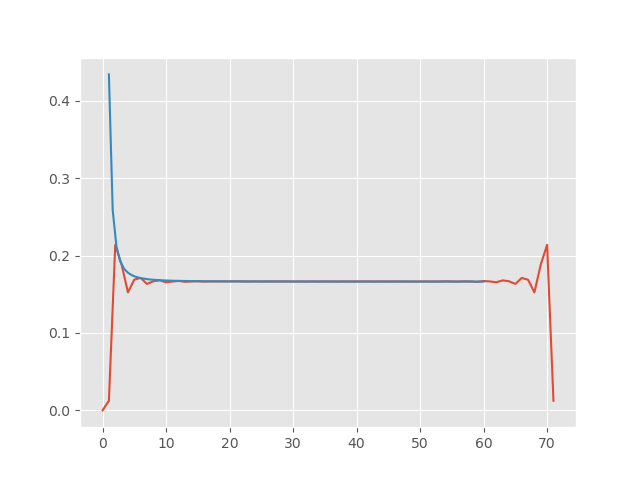

In [93]:
# data = read_accumulator("new-data/finite-t/j0/72x72_r-3_t0.100000_j0.000_20000000.20_0/tri-tri.dat")[0].reshape((72, 72, 2))
data = read_accumulator("new-data/finite-t/j0/72x72_r-3_t0.150000_j0.000_20000000.20_0/tri-tri.dat")[0].reshape((72, 72, 2))
plt.figure()
plt.plot(data[:, 0, 0])

x = np.linspace(1, 60, 100)
def fun(x, A, B, C):
    return A * np.power(np.abs(x), B) + C
param, _ = scipy.optimize.curve_fit(fun, np.arange(72)[3:36:3], data[3:36:3, 0, 0], bounds=([-np.inf, -3, -np.inf], [np.inf, -0.1, np.inf]))
plt.plot(x, fun(x, *param))
print(param)

[ 0.04221749 -0.70424528]


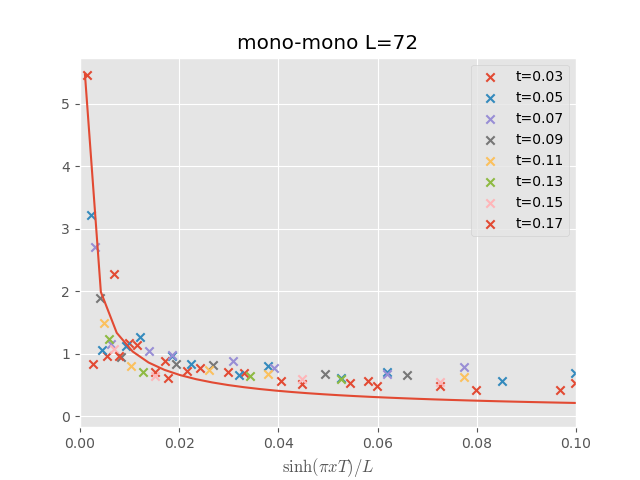

In [165]:
T, data = get_all_data("new-data/finite-t/j-0.05/72*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=100, by="t")

plt.figure()
xs = []
ys = []
for props, d in zip(T, data):
    l = d.shape[0]
    x = np.arange(l)
    # scaledx = np.sin(np.pi * x/l) / (np.pi/l)
    scaledx = np.sinh(np.pi * x * props)
    scaledx = scaledx/l

    # c = d[32:39:3, 0].mean() + d[31:39:3, 0].mean()
    c = d[20:28:3, 0].mean() + d[19:28:3, 0].mean()
    d = d / c

    plt.scatter(scaledx[(x%3!=0)*(x<l//2)], d[(x%3!=0)*(x<l//2), 0], marker="x", label="t="+str(props))
    # plt.scatter(scaledx, d[:, 0], marker="x", label="t="+str(t))
    for i in range(d.shape[0]//2):
        if i % 3 == 0: continue
        xs.append(scaledx[i])
        ys.append(d[i, 0])


x = np.linspace(0.001, 1/np.pi, 100)
def fun(x, A, C):
    return A * np.power(np.abs(x), C) 
param, _ = scipy.optimize.curve_fit(fun, xs[:20], ys[:20])
plt.plot(x, fun(x, *param))

# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("$\\sinh (\\pi x T) /L$")
plt.xlim([0, 0.1])
plt.legend()
plt.title("mono-mono L=72")
print(param)

In [ ]:
"new-data/finite-t/j0/72*/mono-mono.dat"

# Fixed Density

In [ ]:
plt.close("all")
fig, ax = plt.subplots(1, 3, figsize=[12, 5])
skip=50000

colormap = {"0": "red", "1.12": "blue", "1.48": "green", "1.192": "purple", "1.6": "lime", "1.96": "pink"}

for d in colormap.keys():
    for init in ["rt3", "rand"]:
        l = 48
        ls = "--" if init == "rand" else None
        ts2, ds2 = get_all_cvs(f"new-data/dsweeps/{d}/{init}/*/energy.dat", skip=skip)
        ax[0].plot(ts2, ds2, label=str(l)+init+" "+d, ls=ls, color=colormap[d])
        ts2, ds2 = get_all_energies(f"new-data/dsweeps/{d}/{init}/*/energy.dat", skip=skip)
        ax[1].plot(ts2, ds2, label=str(l)+init+" "+d, ls=ls, color=colormap[d])
        ts2, ds2 = get_all_data(f"new-data/dsweeps/{d}/{init}/*/energy.dat", lambda data, prop: 1-data[0][4]/3/data[0][3]**2, skip=skip)
        ax[2].plot(ts2, ds2, label=str(l)+init+" "+d, ls=ls, color=colormap[d])
ax[2].set_ylim([0, 1])
ax[0].set_ylim([0, 1])

ax[0].legend()
ax[1].legend()

## first order histograms

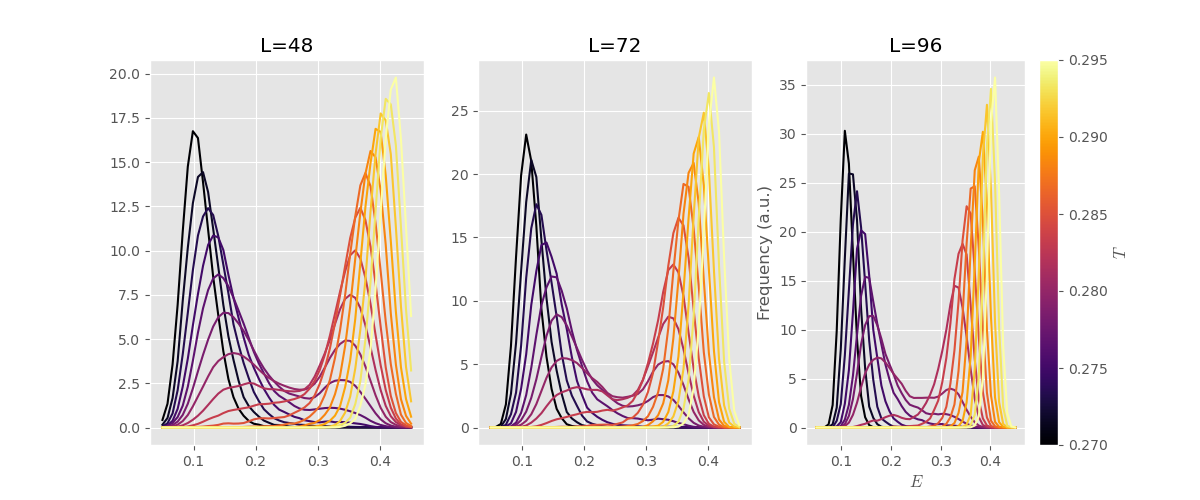

In [8]:
def show_hists(ax, files):
    import seaborn as sns
    for i, f in enumerate(sorted(enum_files(files), key=lambda f: f["t"])):
        e = np.genfromtxt(f["fname"], skip_header=0, max_rows=100000)
        l = f["l"]
        t = f["t"]
        j = f["j4"]
        kde = scipy.stats.gaussian_kde((e[:, 1]*j + e[:, 0])/l/l*3)
        xs = np.linspace(0.05, 0.45, 50)
        ax.plot(xs, kde(xs), color=matplotlib.colormaps["inferno"](i/15))

        # ax.hist((e[:, 1]*j + e[:, 0])/l/l*3, bins=50, histtype="step", density=True, lw=1, color=matplotlib.colormaps["inferno"](i/15))

fig, ax = plt.subplots(1, 3, figsize=[12, 5])

# show_hists(ax[0], "new-data/vsweeps/binder/0.4/84*/energy-single.dat")
# show_hists(ax[1], "new-data/vsweeps/binder/0.5b/84*/energy-single.dat")
# show_hists(ax[2], "new-data/vsweeps/binder/0.6b/84*/energy-single.dat")

# show_hists(ax[0], "new-data/ehist/0.1/48x48*/energy-single.dat")
# show_hists(ax[1], "new-data/ehist/0.1/72x72*/energy-single.dat")
# show_hists(ax[2], "new-data/ehist/0.1/96x96*/energy-single.dat")

show_hists(ax[0], "new-data/ehist/0.3/48*/energy-single.dat")
show_hists(ax[1], "new-data/ehist/0.3/72*/energy-single.dat")
show_hists(ax[2], "new-data/ehist/0.3/96*/energy-single.dat")

# show_hists(ax[0], "new-data/ehist/0.3/48*t0.275000*/energy-single.dat")
# show_hists(ax[0], "new-data/ehist/0.3/48*t0.279933*/energy-single.dat")
# show_hists(ax[0], "new-data/ehist/0.3/48*t0.280424*/energy-single.dat")
# show_hists(ax[0], "new-data/ehist/0.3/48*t0.281543*/energy-single.dat")
# show_hists(ax[0], "new-data/ehist/0.3/48*t0.293000*/energy-single.dat")

# show_hists(ax[1], "new-data/ehist/0.3/72*t0.275000*/energy-single.dat")
# show_hists(ax[1], "new-data/ehist/0.3/72*t0.278998*/energy-single.dat")
# show_hists(ax[1], "new-data/ehist/0.3/72*t0.279445*/energy-single.dat")
# show_hists(ax[1], "new-data/ehist/0.3/72*t0.280096*/energy-single.dat")
# show_hists(ax[1], "new-data/ehist/0.3/72*t0.290000*/energy-single.dat")

# show_hists(ax[2], "new-data/ehist/0.3/96*t0.275000*/energy-single.dat")
# show_hists(ax[2], "new-data/ehist/0.3/96*t0.279541*/energy-single.dat")
# show_hists(ax[2], "new-data/ehist/0.3/96*t0.279939*/energy-single.dat")
# show_hists(ax[2], "new-data/ehist/0.3/96*t0.280510*/energy-single.dat")
# show_hists(ax[2], "new-data/ehist/0.3/96*t0.290000*/energy-single.dat")

# show_hists(ax[0], "new-data/ehist/1/48x48*/energy-single.dat")
# show_hists(ax[1], "new-data/ehist/1/72x72*/energy-single.dat")
# show_hists(ax[2], "new-data/ehist/1/96x96*/energy-single.dat")

ax[0].set_title("L=48")
ax[1].set_title("L=72")
ax[2].set_title("L=96")

ax[2].set_xlabel("$E$")
ax[2].set_ylabel("Frequency (a.u.)")
plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0.27, vmax=0.295), cmap="inferno"), ax=ax[2], label="$T$")

In [ ]:
plt.figure()
c = [c for c in get_all_curves(["new-data/vsweeps/binder/0.1b/*/cluster-count.dat"], prop="mono")]
colors = gen_colors(c)
for a, b, c in c:
    plt.plot(b, c, color=colors[a])

c = [c for c in get_all_curves(["new-data/vsweeps/binder/0.2d/*/cluster-count.dat"], prop="mono")]
colors = gen_colors(c)
for a, b, c in c:
    plt.plot(b, c, color=colors[a])

c = [c for c in get_all_curves(["new-data/vsweeps/binder/0.3/*/cluster-count.dat"], prop="mono")]
colors = gen_colors(c)
for a, b, c in c:
    plt.plot(b, c, color=colors[a])

c = [c for c in get_all_curves(["new-data/vsweeps/binder/1/*/cluster-count.dat"], prop="mono")]
colors = gen_colors(c)
for a, b, c in c:
    plt.plot(b, c, color=colors[a])

a, b = get_all_data("new-data/vsweeps/single/0/48*/cluster-count.dat", lambda data, props: data[0][0]/48/48, by="t")
plt.plot(a, b)
plt.xlim([0, 1])

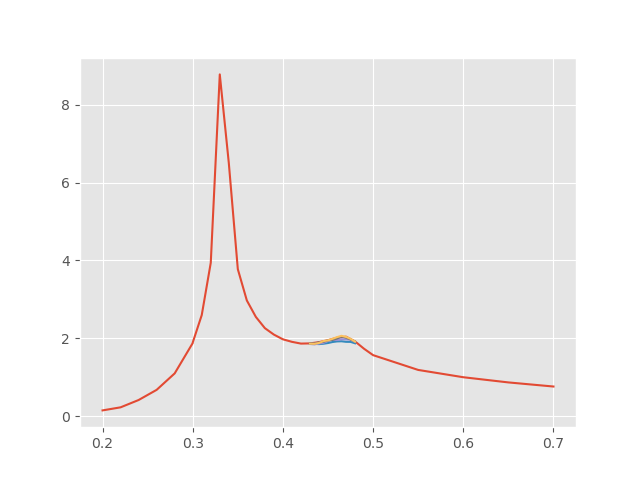

In [117]:
plt.figure()
c = [c for c in get_all_curves(["new-data/vsweeps/single/1/*/energy.dat"], prop="cv", skip=10000)]
colors = gen_colors(c)
for a, b, c in c:
    plt.plot(b, c)

c = [c for c in get_all_curves(["new-data/temp/*/energy.dat"], prop="cv", skip=10000)]
colors = gen_colors(c)
for a, b, c in c:
    plt.plot(b, c)

index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with size 8
index 8 is out of bounds for axis 0 with

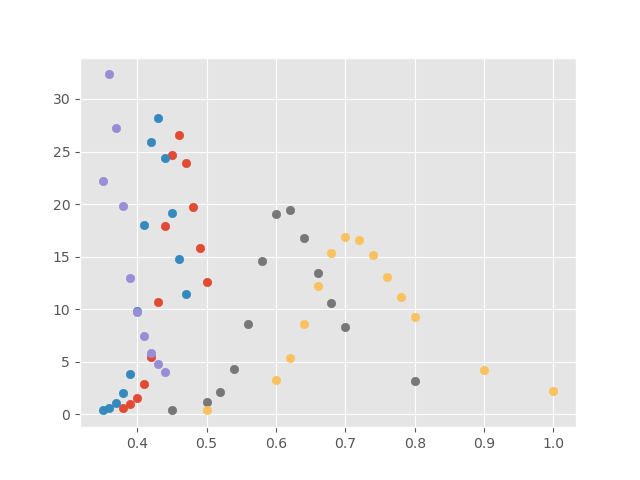

In [21]:
plt.figure()
for j in ["0.9", "0.8", "0.6", "1.5", "2"]:
    c = [c for c in get_all_curves([f"new-data/vsweeps/single/{j}/*/order.dat"], prop="ssus", skip=0)]
    colors = gen_colors(c)
    for a, b, c in c:
        plt.scatter(b, c)